In [2]:
using DLWGMMIV
using LinearAlgebra, Plots, DataFrames, DataFramesMeta

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **


AbstractDict{String, Array{Float64, 1}}}) in module DLWGMMIV at c:\Users\kgovernor\.julia\dev\DLWGMMIV\src\types.jl:114 overwritten at c:\Users\kgovernor\.julia\dev\DLWGMMIV\src\types.jl:127.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [3]:
N = 1000
T = 15
params = Parameters(
    # omega_coefs = [0, 0.8],
    # cost_exps = [1, 1.15]
)
model = ACF_model(
    use_constant = false,
    omega_deg = 3,
    stage2_deg = 2,
)

by = ["t", "n"]
yvar = ["Y"]
xvars1 = ["x1","x2"]
xvars2 = ["x1","x2"]
zvars = ["x1","x2_lag"]

vars = (
    by = ["t", "n"],
    yvar = ["Y"],
    xvars1 = ["x1","x2"],
    xvars2 = [xvars2; DLWGMMIV.poly_vars(xvars2,  model.s2_deg).v],
    zvars = [zvars; DLWGMMIV.poly_vars(zvars,  model.s2_deg).v],
    phivar = "phi"
);

In [4]:
df_main = simfirmdata(
    N, T, 
    params = params, 
	seed = 1,
	opt_error = 0
)


  First order derivative at optimal L is approximately zero: true

  Second order derivative at optimal L check: true


Row,t,n,FC,OMEGA,XI,OMEGA_x1,XI_x1,OMEGA_x2,XI_x2,x1,x2,Y,TC,P,termination,C_x1,rent_x1,shareTC_x1,shareY_x1,C_x2,rent_x2,shareTC_x2,shareY_x2
,Int64,Int64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,String,Real,Float64,Float64,Float64,Real,Float64,Float64,Float64
1,1,1,0.0,-0.416707,-0.416707,0.0,0.0,0.0,0.0,9.01998,0.794051,1.76422,0.767053,0.997169,closed_solve,0.0,0.0,0.0,0.0,0.767053,0.966,1.0,0.434783
2,1,2,0.0,0.392683,0.392683,0.0,0.0,0.0,0.0,3.23118,1.25222,2.97893,1.29519,1.68374,closed_solve,0.0,0.0,0.0,0.0,1.29519,1.03431,1.0,0.434783
3,1,3,0.0,-1.5312,-1.5312,0.0,0.0,0.0,0.0,3.85714,0.0743714,0.115836,0.0503636,0.0654727,closed_solve,0.0,0.0,0.0,0.0,0.0503636,0.677191,1.0,0.434783
4,1,4,0.0,0.122322,0.122322,0.0,0.0,0.0,0.0,1.34223,0.420293,0.848815,0.36905,0.479765,closed_solve,0.0,0.0,0.0,0.0,0.36905,0.878078,1.0,0.434783
5,1,5,0.0,0.765969,0.765969,0.0,0.0,0.0,0.0,0.339542,0.393028,0.785804,0.341654,0.44415,closed_solve,0.0,0.0,0.0,0.0,0.341654,0.869288,1.0,0.434783
6,1,6,0.0,0.108348,0.108348,0.0,0.0,0.0,0.0,0.598674,0.221053,0.405413,0.176267,0.229147,closed_solve,0.0,0.0,0.0,0.0,0.176267,0.797397,1.0,0.434783
7,1,7,0.0,-0.800419,-0.800419,0.0,0.0,0.0,0.0,0.657391,0.05869,0.0882219,0.0383573,0.0498646,closed_solve,0.0,0.0,0.0,0.0,0.0383573,0.653559,1.0,0.434783
8,1,8,0.0,1.50986,1.50986,0.0,0.0,0.0,0.0,2.6285,5.95877,17.9126,7.78808,10.1245,closed_solve,0.0,0.0,0.0,0.0,7.78808,1.30699,1.0,0.434783
9,1,9,0.0,0.0770233,0.0770233,0.0,0.0,0.0,0.0,1.58281,0.445006,0.906461,0.394113,0.512347,closed_solve,0.0,0.0,0.0,0.0,0.394113,0.885635,1.0,0.434783


In [5]:
df = deepcopy(df_main)
df[:, unique([yvar; xvars1; xvars2])] = log.(df[:, unique([yvar;xvars1;xvars2])])
df = lag_panel(df, by, ["x2"])
df[:, vars.phivar] = df.Y
for v in [xvars2, zvars]
    global df = DLWGMMIV.poly_approx_vars(df, model.s2_deg, v)
end

In [6]:
Z = Matrix(df[completecases(df), vars.zvars])
prodest = DLWGMMIV.prodest_method(model.method)
cache = DLWGMMIV.Cache([], [], [])

f(betas, gbetas; derivative = []) = prodest(betas, gbetas, df, vars, model.g_B, derivative = derivative)
gf(betas) = prodest(betas, df, vars, model.g_B, model.use_constant)
V(betas) = DLWGMMIV.solveXI(cache, betas, f, gf, model, Z);

In [7]:
start, stop = 0, 1
l = abs(stop - start) * 100
x1s = range(start, stop, length=l)
x2s = x1s
Y = [V([x1,x2,0,0,0]) for x1 in x1s, x2 in x2s];

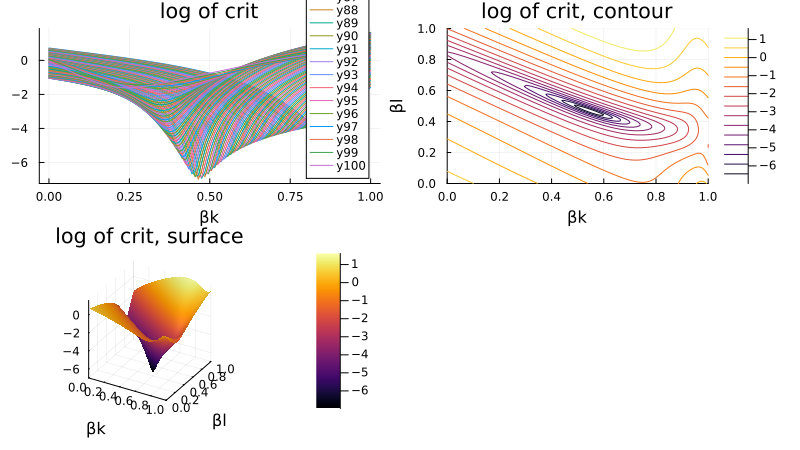

In [8]:
p1 = plot(
    x1s, log.(Y), title = "log of crit", xlabel = "βk", legend = false
)

p2 = plot(
    x1s, x2s, log.(Y), title = "log of crit, contour", xlabel = "βk", ylabel = "βl", st=:contour
)

p3 = plot(
    x1s, x2s, log.(Y), title = "log of crit, surface", xlabel = "βk", ylabel = "βl", st=:surface
)

ratio = 9/16
width = 800
pp = plot(p1, p2, p3, size = (width, width*ratio))